# Packages and libraries

In [ ]:
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics


# Training with Transformers for Time series
Only Ethereum price

In [ ]:
#eth = pd.read_csv('..\Data\Training\Ethereum.csv')
eth = pd.read_csv('Ethereum.csv')

In [ ]:
# Calculate denormalization factor
denormalization_factor = 1000
print("Denormalization Factor:", denormalization_factor)

Denormalization Factor: 1000


In [ ]:
data = eth

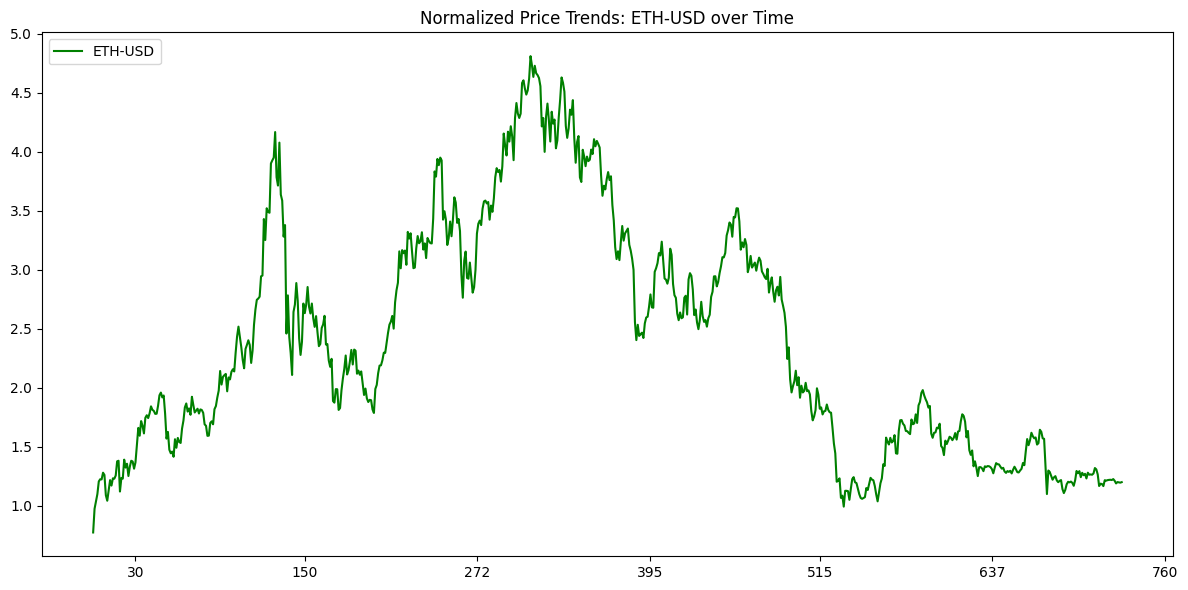

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
import numpy as np

# Assuming ax1 is already defined
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot ETH-USD on the right y-axis
ax1.plot(data["dates"].index, eth["close_eth"], label='ETH-USD', color='green')

# Add legend
ax1.legend(loc='upper left')

ax1.xaxis.set_major_locator(MonthLocator(bymonthday=-1, interval=4))
plt.title('Normalized Price Trends: ETH-USD over Time')

fig.tight_layout()
plt.show()

In [ ]:
eth["dates"] = pd.to_datetime(eth["dates"])
eth = eth.sort_values(by="dates")

In [ ]:
#drop dates after sorting
dates = eth["dates"][-141:]
eth = eth.drop(["dates"],axis =1)

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(eth["close_eth"], test_size=0.20, shuffle=False)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print("Training set has {} observations.".format(len(df_train)))
print("Test set has {} observations.".format(len(df_test)))

Training set has 584 observations.
Test set has 146 observations.


In [ ]:
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x),np.array(y)

In [ ]:
SEQUENCE_SIZE = 5
X_train,y_train = to_sequences(SEQUENCE_SIZE,df_train)
X_test,y_test = to_sequences(SEQUENCE_SIZE,df_test)

print("Shape of training set: {}".format(X_train.shape))
print("Shape of test set: {}".format(X_test.shape))

Shape of training set: (579, 5, 1)
Shape of test set: (141, 5, 1)


In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(input_shape,head_size,num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout=0,mlp_dropout=0,):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[],
    mlp_dropout=0.3,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

In [ ]:
import tensorflow as tf
#tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, \
    restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(X_test, y_test, verbose=1)

Epoch 1/200
8/8 [==============================] - 23s 147ms/step - loss: 0.1213 - val_loss: 0.0286
Epoch 2/200
8/8 [==============================] - 0s 25ms/step - loss: 0.0636 - val_loss: 0.0214
Epoch 3/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0539 - val_loss: 0.0318
Epoch 4/200
8/8 [==============================] - 0s 24ms/step - loss: 0.0533 - val_loss: 0.0315
Epoch 5/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0551 - val_loss: 0.0243
Epoch 6/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0524 - val_loss: 0.0202
Epoch 7/200
8/8 [==============================] - 0s 24ms/step - loss: 0.0509 - val_loss: 0.0199
Epoch 8/200
8/8 [==============================] - 0s 24ms/step - loss: 0.0487 - val_loss: 0.0204
Epoch 9/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0503 - val_loss: 0.0210
Epoch 10/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0504 - val_loss: 0.0216
Epoch 11/200
8/8 

0.005137656349688768

In [ ]:
pred = model.predict(X_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

5/5 [==============================] - 0s 5ms/step
Score (RMSE): 0.07167744239689211


In [ ]:
mse_score = metrics.mean_squared_error(pred, y_test)
print("MSE Score: {}".format(mse_score))

MSE Score: 0.005137655748559788


In [ ]:
mape_score = np.mean(np.abs((y_test - pred) / y_test)) * 100
print("MAPE Score: {}".format(mape_score))

MAPE Score: 14.911606009203899


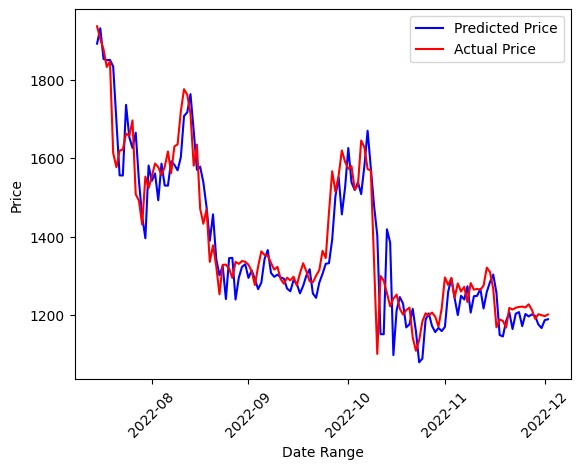

In [ ]:
# Plot predicted and actual prices
plt.plot(dates, pred[-141:] * 1000, label='Predicted Price', color='b')
plt.plot(dates, y_test[-141:] * 1000, label='Actual Price', color='red')

plt.xlabel('Date Range')
plt.ylabel('Price')
plt.legend()

# Show dates after every two months
plt.gca().xaxis.set_major_locator(MonthLocator(bymonthday=-1, interval=1))

# Rotate x-axis labels for better presentation
plt.xticks(rotation=45)

plt.show()

In [22]:
predicted = pd.DataFrame(pred,columns=["values"])
predicted["dates"] = np.array(dates)
predicted["actual"] = np.array(y_test[-141:])
predicted.to_csv("Ethprices.csv")